In [11]:
import pandas as pd
from dsipts import TimeSeries, RNN,Monash,get_freq


In [12]:
m = Monash(filename='monash',baseUrl='https://forecastingdata.org/', rebuild=True)
m.download_dataset('data',4656144,rebuild=True)
m.save('monash')

/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/dsipts-0.0.1-py3.11.egg/dsipts/data_management/monash.py:225: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 225 of the file /home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/dsipts-0.0.1-py3.11.egg/dsipts/data_management/monash.py. To get rid of this warning, pass the additional argument 'features="html5lib"' to the BeautifulSoup constructor.

/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/dsipts-0.0.1-py3.11.egg/dsipts/data_management/monash.py:313: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a pro

In [13]:
m = Monash(filename='monash',baseUrl='https://forecastingdata.org/', rebuild=False)
m.load('monash')
m.downloaded.keys()


dict_keys([4656144])

In [14]:

loaded_data,frequency,forecast_horizon,contain_missing_values,contain_equal_length = m.generate_dataset(4656144)


In [15]:
loaded_data

,series_name,start_timestamp,series_value
0,T1,2006-01-01 00:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,T2,2006-01-01 00:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,T3,2006-01-01 00:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,T4,2006-01-01 00:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,T5,2006-01-01 00:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
132,T133,2006-01-01 00:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
133,T134,2006-01-01 00:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
134,T135,2006-01-01 00:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
135,T136,2006-01-01 00:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


'10_minutes'

In [17]:
serie = pd.DataFrame({'signal':loaded_data.series_value.iloc[0]})
serie['time'] = pd.date_range(start = loaded_data.start_timestamp.iloc[0], periods=  serie.shape[0],freq=get_freq(frequency))
serie['cum'] = serie.time.dt.minute  + serie.time.dt.hour 
starting_point = {'cum':0} ##this can be used for creating the dataset: only samples with cum=0 in the first future lag will be used as samples! 
ts = TimeSeries('4656144')
ts.load_signal(serie.iloc[0:8000],enrich_cat=['dow','hour'],target_variables=['signal'])

In [57]:
ts.plot();

/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/plotly-5.17.0-py3.11.egg/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [40]:
past_steps = 100
future_steps = 20
config = dict(model_configs =dict(
                                    cat_emb_dim = 16,
                                    kind = 'gru',
                                    hidden_RNN = 32,
                                    num_layers_RNN = 2,
                                    sum_emb = True,
                                    kernel_size = 15,
                                    past_steps = past_steps,
                                    future_steps = future_steps,
                                    past_channels = len(ts.num_var),
                                    future_channels = len(ts.future_variables),
                                    embs = [ts.dataset[c].nunique() for c in ts.cat_var],
                                    quantiles=[0.1,0.5,0.9],
                                    dropout_rate= 0.25,
                                    persistence_weight= 0.010,
                                    loss_type= 'l1',
                                    remove_last= True,
                                    use_bn = False,
                                    optim= 'torch.optim.Adam',
                                    activation= 'torch.nn.GELU', 
                                    verbose = True,
                                    out_channels = len(ts.target_variables)),
                scheduler_config = dict(gamma=0.1,step_size=100),
                optim_config = dict(lr = 0.0005,weight_decay=0.01))
model_sum = RNN(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'] )
ts.set_model(model_sum,config=config )

/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning:

Initializing zero-element tensors is a no-op



In [41]:
ts.set_model(model_sum,config=config )

In [42]:
ts.train_model(dirpath="/home/agobbi/Projects/TT/tmp/4656719v2",split_params=dict(perc_train=0.6, perc_valid=0.2,past_steps = past_steps,future_steps=future_steps, range_train=None, range_validation=None, range_test=None,shift = 0,starting_point=None,skip_step=1),batch_size=100,num_workers=4,max_epochs=40,auto_lr_find=True,devices='auto')

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/pytorch_lightning-1.9.4-py3.11.egg/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning:

Checkpoint directory /home/agobbi/Projects/TT/tmp/4656719v2 exists and is not empty.

/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/pytorch_lightning-1.9.4-py3.11.egg/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning:

The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/pytorch_lightning-1.9.4-py3.11.egg/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning:

Your `val_dataloader`'s sampler has shuffling enab

Saving losses on file because multigpu not working


/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning:

Initializing zero-element tensors is a no-op



5.992373943328857

<Axes: >

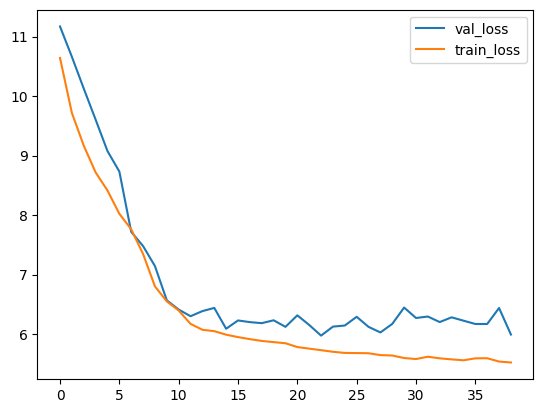

In [51]:
ts.losses.plot()

In [52]:
res = ts.inference_on_set(set='test',batch_size=100,num_workers=4)
res.head()

,lag,time,signal,signal_low,signal_median,signal_high,prediction_time
0,1,2006-02-15 03:20:01,-2.009074e-07,-0.549594,0.100784,1.977910,2006-02-15 03:10:01
1,1,2006-02-15 03:30:01,-2.009074e-07,-0.552458,0.108085,1.980531,2006-02-15 03:20:01
2,1,2006-02-15 03:40:01,-2.009074e-07,-0.571291,0.102462,1.979137,2006-02-15 03:30:01
3,1,2006-02-15 03:50:01,-2.009074e-07,-0.586380,0.115378,1.988222,2006-02-15 03:40:01
4,1,2006-02-15 04:00:01,-2.009074e-07,-0.622420,0.110776,1.990789,2006-02-15 03:50:01


In [54]:
ts.save('tmp')
ts.load( RNN,'tmp',load_last=True)

/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning:

Initializing zero-element tensors is a no-op



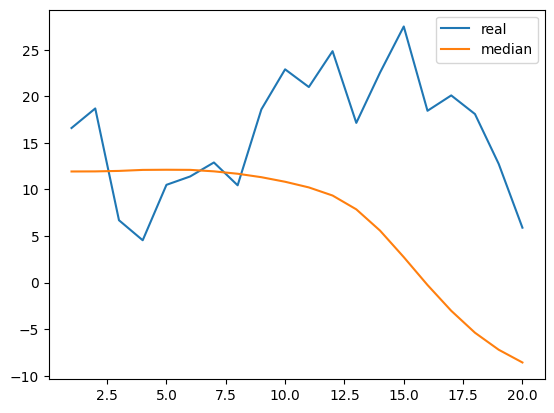

In [55]:
import matplotlib.pyplot as plt
mask = res.prediction_time=='2006-02-15 13:20:01'
plt.plot(res.lag[mask],res.signal[mask],label='real')
plt.plot(res.lag[mask],res.signal_median[mask],label='median')
plt.legend()

<Axes: xlabel='lag'>

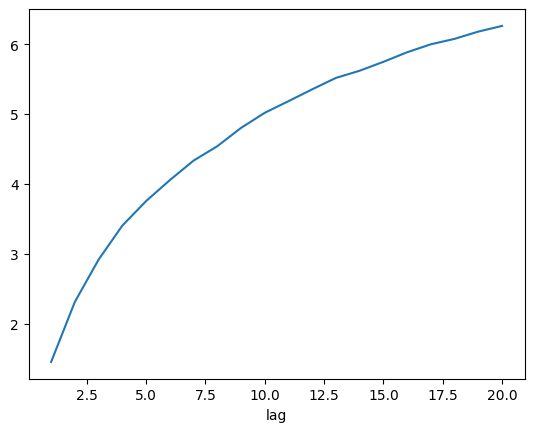

In [56]:
import numpy as np
res['error'] =np.abs( res['signal']-res['signal_median'])
res.groupby('lag').error.mean().plot()